In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/e4_general_model.npz', allow_pickle=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Access the saved data from the .npz file
all_DeviceStatus = data['all_DeviceStatus']
device_count = data['device_count']
num_samples = data['num_samples']

In [4]:
# Generate unique pilots
def generate_pilots(num_pilots, seq_length):
  pilots = np.zeros((num_pilots, seq_length), dtype=complex)
  seen_pilots = set()  # To track already generated pilots

  for i in range(num_pilots):
    while True:
      # Generate random QPSK symbols (0, 1, 2, 3)
      symbols = np.random.randint(0, 4, seq_length)

      # Generate QPSK symbols: Exp(1j * (np.pi / 2) * (symbol + 1/2)) to map symbols to QPSK constellation
      qpsk_symbols = np.exp(1j * (np.pi / 2) * (symbols + 1 / 2)) * np.sqrt(2)

      # Normalize the pilot sequence
      pilot = qpsk_symbols / np.sqrt(seq_length)

      # Check if this pilot sequence has already been generated
      pilot_tuple = tuple(pilot)  # Convert to tuple to store in set (tuples are hashable)

      if pilot_tuple not in seen_pilots:  # If it's a unique sequence
        pilots[i, :] = pilot  # Store the pilot
        seen_pilots.add(pilot_tuple)  # Mark this pilot sequence as seen
        break  # Exit while loop and move to the next pilot

  return pilots

In [5]:
# Given SNR in dB
def snr_to_linear(SNR_dB):
  return 10 ** (SNR_dB / 10)

In [6]:
# Simulate the communication model for one SNR level and one time step
def simulate_communication(SNR_dB, theta, Gamma, Z, seq_length):
  # Convert SNR from dB to linear scale
  SNR = 10 ** (SNR_dB / 10)

  # Signal power calculation
  signal_power = np.mean(np.abs(np.dot(theta, Z))**2)

  # Noise power calculation based on SNR
  noise_power = signal_power / SNR

  # Generate noise (Gaussian)
  noise = np.sqrt(noise_power / 2) * (np.random.randn(seq_length, M) + 1j * np.random.randn(seq_length, M))

  # Received signal
  received_signal = np.matmul(theta, Z) + noise

  return noise, received_signal

In [7]:
import numpy as np

def run_simulations(snr_db_Array, pilot_length_Array, sample_index, DeviceStatus, device_count, M):
    # Preallocate lists to store noise and received signal for each pilot length and SNR value
    single_sample_noise = np.zeros((len(pilot_length_array), len(snr_db_array), max(pilot_length_array), M), dtype=complex)
    single_sample_received_signal = np.zeros((len(pilot_length_array), len(snr_db_array), max(pilot_length_array), M), dtype=complex)
    single_sample_theta = np.zeros((len(pilot_length_array), max(pilot_length_array), device_count), dtype=complex)

    # Generate the Z matrix (signal with channel, complex-valued)
    z = np.sqrt(1 / 2) * (np.random.multivariate_normal(np.zeros(device_count), np.diag(DeviceStatus), size=M) +
                          1j * np.random.multivariate_normal(np.zeros(device_count), np.diag(DeviceStatus), size=M)).T

    # Loop through each pilot length in pilot_length_Array
    for pilot_length_index, pilot_length in enumerate(pilot_length_Array):
        print(f"  Simulating for Pilot length = {pilot_length} (Index {pilot_length_index})...")

        # Generate pilots for the sample (same pilots for all SNR levels)
        pilots = generate_pilots(device_count, pilot_length)
        theta = pilots.T  # Same theta for all SNR levels

        # Store theta in the pre-allocated array
        single_sample_theta[pilot_length_index, :pilot_length, :] = theta

        # Simulate communication for each SNR value in snr_db_Array
        for snr_db_index, snr_db in enumerate(snr_db_Array):
            print(f"    Simulating for SNR = {snr_db} dB (Index {snr_db_index})...")

            # Simulate the communication for the current SNR value and sample
            noise, received_signal = simulate_communication(snr_db, theta, DeviceStatus, z, pilot_length)

            # Assign the relevant part (up to the pilot_length) of the noise and received_signal arrays
            single_sample_noise[pilot_length_index, snr_db_index, :pilot_length, :] = noise
            single_sample_received_signal[pilot_length_index, snr_db_index, :pilot_length, :] = received_signal

            # Print feedback for the current SNR value and sample index
            print(f"      Simulated Pilot length = {pilot_length}, SNR = {snr_db} dB for Sample {sample_index + 1}")

    # Return the results: theta, DeviceStatus, Z, noise, and received signal arrays
    return single_sample_theta, DeviceStatus, z, single_sample_noise, single_sample_received_signal


In [8]:
snr_db_array = np.arange(4, 25, 4)
pilot_length_array = np.arange(20, 42, 4)
M = 4

In [9]:
import numpy as np

# Initialize variables as lists of empty lists for each sample
all_theta = np.zeros((num_samples, len(pilot_length_array), max(pilot_length_array), device_count), dtype=complex)
all_gamma = np.zeros((num_samples, device_count), dtype=bool)
all_z = np.zeros((num_samples, device_count, M), dtype=complex)
all_noise = np.zeros((num_samples, len(pilot_length_array), len(snr_db_array), max(pilot_length_array), M), dtype=complex)
all_received_signal = np.zeros((num_samples, len(pilot_length_array), len(snr_db_array), max(pilot_length_array), M), dtype=complex)

# Loop through each sample from the loaded data
for sample_index in range(num_samples):
    print(f"\nRunning simulation for Sample {sample_index + 1}...")

    # Extract the device status for the current sample
    DeviceStatus = all_DeviceStatus[sample_index]

    # Run the simulation for this sample, using the saved parameters
    # Generate pilots and simulate for each SNR level
    single_sample_theta, gamma, z, single_sample_noise, single_sample_received_signal = run_simulations(
        snr_db_array, pilot_length_array, sample_index, DeviceStatus, device_count, M
    )

    # Append results for each sample into their respective lists
    all_theta[sample_index, :, :, :] = single_sample_theta
    all_gamma[sample_index, :] = gamma
    all_z[sample_index, :, :] = z
    all_noise[sample_index, :, :, :, :] = single_sample_noise
    all_received_signal[sample_index, :, :, :, :] = single_sample_received_signal

    print(f"Completed simulation for Sample {sample_index + 1}")

# Save all collected results to a .npz file
np.savez_compressed('/content/drive/My Drive/Github/mtc-device-activation/e4_communication_simulation.npz',
                    all_theta=all_theta,
                    all_gamma=all_gamma,
                    all_z=all_z,
                    all_noise=all_noise,
                    all_received_signal=all_received_signal,
                    pilot_length_array=pilot_length_array,
                    snr_db_array=snr_db_array,
                    M=M)

print("All simulation results have been saved to 'e4_communication_simulation.npz'.")


Streaming output truncated to the last 5000 lines.
      Simulated Pilot length = 24, SNR = 16 dB for Sample 939
    Simulating for SNR = 20 dB (Index 4)...
      Simulated Pilot length = 24, SNR = 20 dB for Sample 939
    Simulating for SNR = 24 dB (Index 5)...
      Simulated Pilot length = 24, SNR = 24 dB for Sample 939
  Simulating for Pilot length = 28 (Index 2)...
    Simulating for SNR = 4 dB (Index 0)...
      Simulated Pilot length = 28, SNR = 4 dB for Sample 939
    Simulating for SNR = 8 dB (Index 1)...
      Simulated Pilot length = 28, SNR = 8 dB for Sample 939
    Simulating for SNR = 12 dB (Index 2)...
      Simulated Pilot length = 28, SNR = 12 dB for Sample 939
    Simulating for SNR = 16 dB (Index 3)...
      Simulated Pilot length = 28, SNR = 16 dB for Sample 939
    Simulating for SNR = 20 dB (Index 4)...
      Simulated Pilot length = 28, SNR = 20 dB for Sample 939
    Simulating for SNR = 24 dB (Index 5)...
      Simulated Pilot length = 28, SNR = 24 dB for Sample

Shape of z: (400, 4)
Shape of Gamma: (400,)
Shape of received_signal: (40, 4)
Shape of noise: (40, 4)


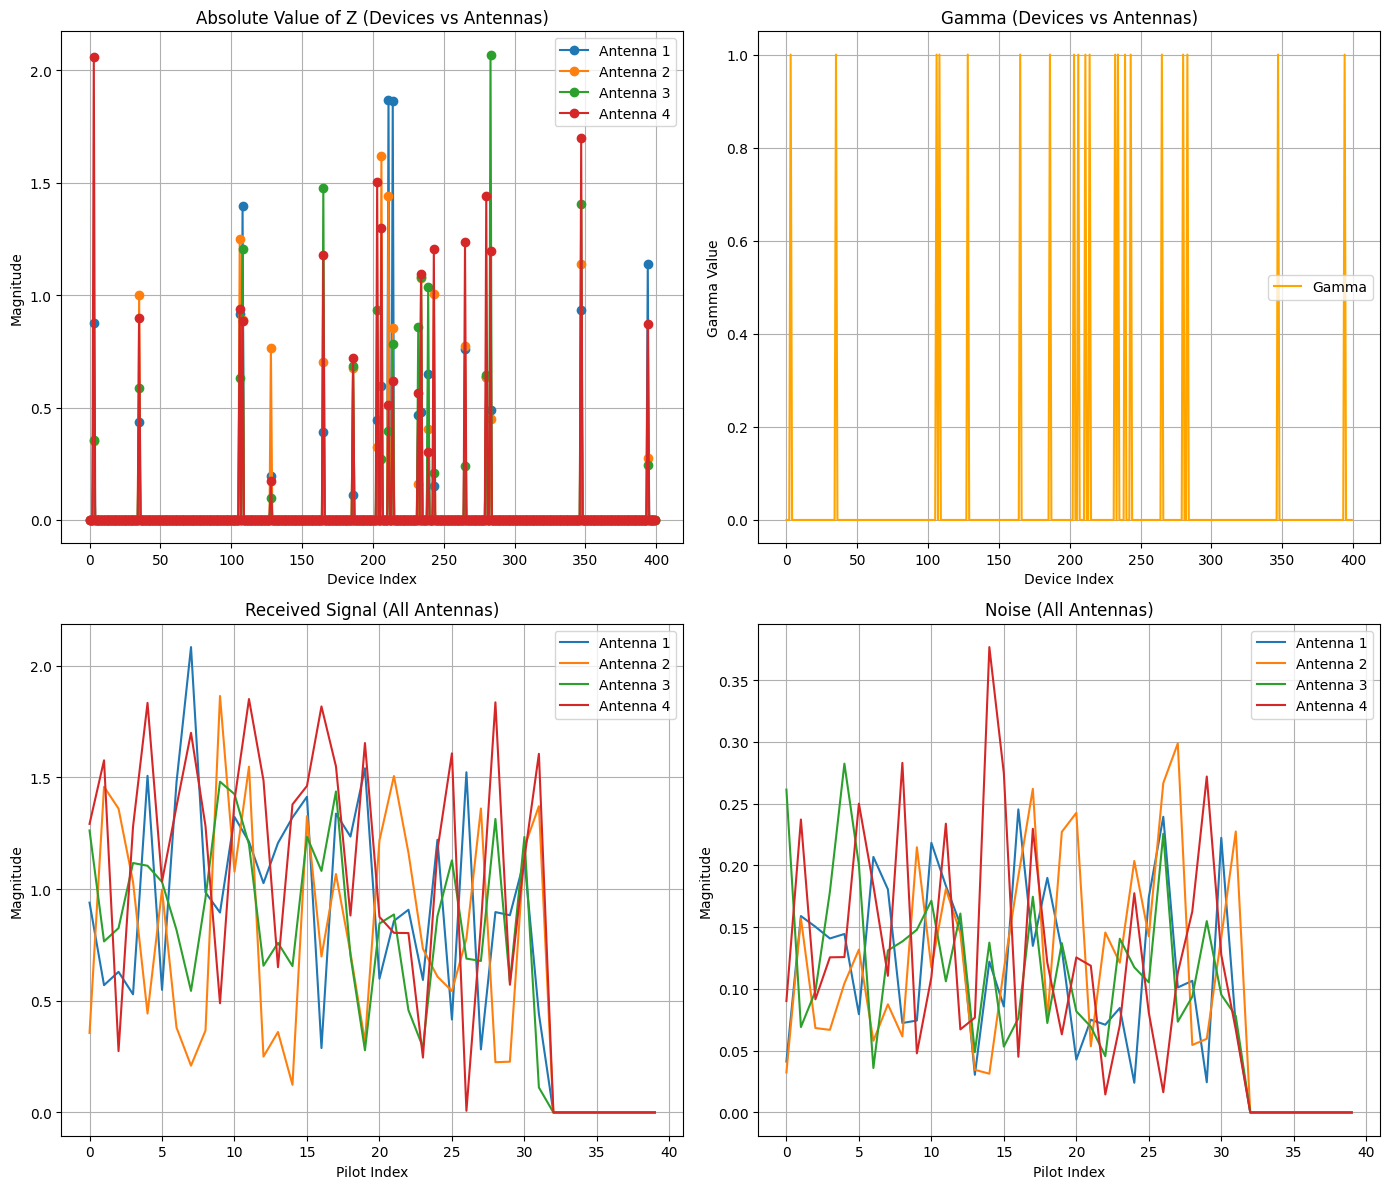

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Load saved data for the simulation
simulation_data = np.load('/content/drive/My Drive/Github/mtc-device-activation/e4_communication_simulation.npz', allow_pickle=True)

# Select sample index (modify if needed)
sample_index = 0  # Change this to the sample index you wish to view
snr_db_index = 3  # Change this to the SNR index you wish to view
pilot_length_index = 3

# Extract the 'Z', 'Gamma', 'Received Signal', and 'Noise' data for the selected sample
z = simulation_data['all_z'][sample_index]  # Shape (num_devices, M)
gamma = simulation_data['all_gamma'][sample_index]  # Shape (num_devices,)
received_signal = simulation_data['all_received_signal'][sample_index, pilot_length_index, snr_db_index]  # Shape (seq_length, M)
noise = simulation_data['all_noise'][sample_index, pilot_length_index, snr_db_index]  # Shape (seq_length, M)

# Print the shapes of these arrays for debugging
print("Shape of z:", z.shape)
print("Shape of Gamma:", gamma.shape)
print("Shape of received_signal:", received_signal.shape)
print("Shape of noise:", noise.shape)

# Handle the number of devices based on Z's shape
num_devices = z.shape[0]  # This is the number of devices
M = z.shape[1]  # This is the number of antennas
seq_length = received_signal.shape[0]  # This is the number of pilots (sequence length)

# Create a figure to display the absolute value of Z, Gamma, received signal, and noise for all devices
plt.figure(figsize=(14, 12))

# Plot Z for all devices and antennas (x-axis: devices, y-axis: magnitude) with lines and dots
plt.subplot(2, 2, 1)
for antenna_index in range(M):
    plt.plot(np.abs(z[:, antenna_index]), '-o', label=f'Antenna {antenna_index + 1}')  # Use both line and dots ('-o')
plt.title('Absolute Value of Z (Devices vs Antennas)')
plt.xlabel('Device Index')
plt.ylabel('Magnitude')
plt.grid(True)
plt.legend()

# Plot Gamma for all devices (x-axis: devices, y-axis: Gamma value)
plt.subplot(2, 2, 2)
plt.plot(gamma, label='Gamma', color='orange')
plt.title('Gamma (Devices vs Antennas)')
plt.xlabel('Device Index')
plt.ylabel('Gamma Value')
plt.grid(True)
plt.legend()

# Plot received signal for all antennas on the same plot (pilot index on x-axis, magnitude on y-axis)
plt.subplot(2, 2, 3)
for antenna_index in range(M):
    plt.plot(np.abs(received_signal[:, antenna_index]), label=f'Antenna {antenna_index + 1}')
plt.title('Received Signal (All Antennas)')
plt.xlabel('Pilot Index')
plt.ylabel('Magnitude')
plt.grid(True)
plt.legend()

# Plot noise for all antennas on the same plot (pilot index on x-axis, magnitude on y-axis)
plt.subplot(2, 2, 4)
for antenna_index in range(M):
    plt.plot(np.abs(noise[:, antenna_index]), label=f'Antenna {antenna_index + 1}')
plt.title('Noise (All Antennas)')
plt.xlabel('Pilot Index')
plt.ylabel('Magnitude')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
